# Transfer Learning with MobileNetV2

Bienvenido a la tarea de esta semana, en la que utilizarás el aprendizaje por transferencia en una CNN preentrenada para construir un clasificador Alpaca/No Alpaca.

Un modelo preentrenado es una red que ya ha sido entrenada en un gran conjunto de datos y que se ha guardado, lo que le permite utilizarla para personalizar su propio modelo de forma económica y eficiente. El modelo que vas a utilizar, MobileNetV2, se ha diseñado para ofrecer un rendimiento rápido y eficiente desde el punto de vista computacional. Ha sido preentrenado en ImageNet, un conjunto de datos que contiene más de 14 millones de imágenes y 1000 clases.

Al final de esta tarea, será capaz de

- Crear un conjunto de datos a partir de un directorio
- Preprocesar y aumentar los datos utilizando la API secuencial
- Adaptar un modelo preentrenado a los nuevos datos y entrenar un clasificador utilizando la API Funcional y MobileNet
- Ajustar las capas finales de un clasificador para mejorar la precisión 

## Table of Content

- [1 - Packages](#1)
    - [1.1 Create the Dataset and Split it into Training and Validation Sets](#1-1)
- [2 - Preprocess and Augment Training Data](#2)
    - [Exercise 1 - data_augmenter](#ex-1)
- [3 - Using MobileNetV2 for Transfer Learning](#3)
    - [3.1 - Inside a MobileNetV2 Convolutional Building Block](#3-1)
    - [3.2 - Layer Freezing with the Functional API](#3-2)
        - [Exercise 2 - alpaca_model](#ex-2)
    - [3.3 - Fine-tuning the Model](#3-3)
        - [Exercise 3](#ex-3)

<a name='1'></a>
## 1 - Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


<a name='1-1'></a>
### 1.1 Crear el conjunto de datos y dividirlo en conjuntos de entrenamiento y validación

Cuando se entrenan y evalúan modelos de aprendizaje profundo en Keras, generar un conjunto de datos a partir de archivos de imagen almacenados en el disco es sencillo y rápido. Llame a `image_data_set_from_directory()` para leer desde el directorio y crear conjuntos de datos de entrenamiento y validación. 

Si está especificando una división de validación, también tendrá que especificar el subconjunto para cada porción. Simplemente establece el conjunto de entrenamiento como `subset='training'` y el conjunto de validación como `subset='validation'`.

También deberás configurar tus semillas para que coincidan entre sí, de modo que tus conjuntos de entrenamiento y validación no se superpongan :) 

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


Ahora veamos algunas de las imágenes del conjunto de entrenamiento: 

**Nota:** El conjunto de datos original tiene también algunas imágenes mal etiquetadas.

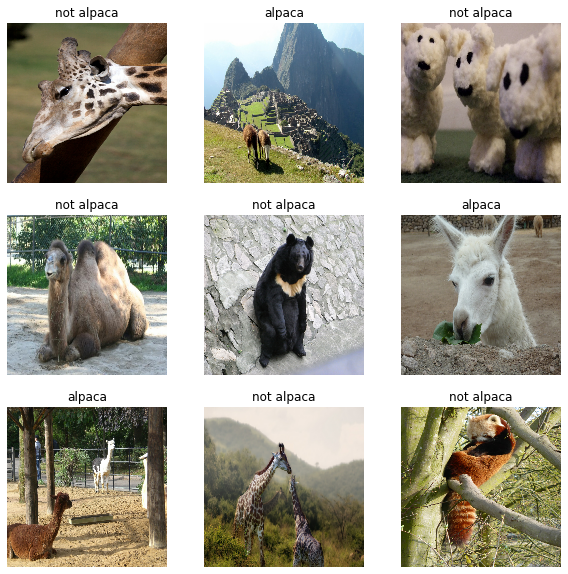

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a name='2'></a>
## 2 - Preprocesar y aumentar los datos de entrenamiento

Es posible que hayas encontrado `dataset.prefetch` en una asignación anterior de TensorFlow, como un importante paso extra en el preprocesamiento de datos. 

El uso de `prefetch()` evita un cuello de botella de memoria que puede ocurrir cuando se lee desde el disco. Se separan algunos datos y se mantienen listos para cuando se necesitan, mediante la creación de un conjunto de datos de origen a partir de sus datos de entrada, aplicando una transformación para preprocesarlos, y luego iterando sobre el conjunto de datos un elemento a la vez. Como la iteración es en flujo, los datos no tienen que caber en la memoria.

Puede establecer el número de elementos a preprocesar manualmente, o puede utilizar `tf.data.experimental.AUTOTUNE` para elegir los parámetros automáticamente. Autotune pide a `tf.data` que ajuste ese valor dinámicamente en tiempo de ejecución, haciendo un seguimiento del tiempo empleado en cada operación y alimentando esos tiempos a un algoritmo de optimización. El algoritmo de optimización trata de encontrar la mejor asignación de su presupuesto de CPU entre todas las operaciones ajustables. 

Para aumentar la diversidad del conjunto de entrenamiento y ayudar al modelo a aprender mejor los datos, es una práctica habitual aumentar las imágenes transformándolas, es decir, volteándolas y rotándolas aleatoriamente. La API secuencial de Keras ofrece un método sencillo para este tipo de aumentos de datos, con capas de preprocesamiento integradas y personalizables. Estas capas se guardan con el resto del modelo y pueden reutilizarse posteriormente.  Ahh, ¡qué práctico! 

Como siempre, te invitamos a leer la documentación oficial, que puedes encontrar para el aumento de datos [aquí](https://www.tensorflow.org/tutorials/images/data_augmentation).


In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

<a name='ex-1'></a>
### Ejercicio 1 - data_augmenter

Implementa una función para el aumento de datos. Utiliza un modelo keras `Secuencial` compuesto por 2 capas:
* `RandomFlip('horizontal')`
* `RandomRotation(0.2)`

In [6]:
# UNQ_C1
# GRADED FUNCTION: data_augmenter
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

In [7]:
augmenter = data_augmenter()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
assert len(augmenter.layers) == 2, "The model must have only 2 layers"

print('\033[92mAll tests passed!')


All tests passed!


Mira cómo se ha aumentado una imagen del conjunto de entrenamiento con transformaciones sencillas:

De un lindo animal, a 9 variaciones de ese lindo animal, en tres líneas de código. Ahora tu modelo tiene mucho más de lo que aprender.

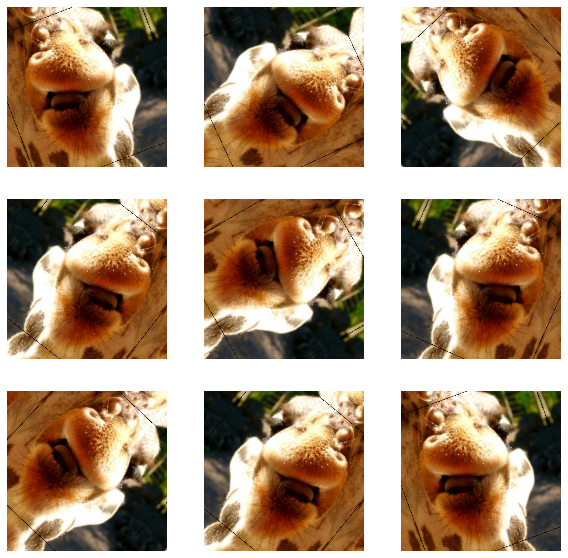

In [8]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

A continuación, aplicarás tu primera herramienta de la aplicación MobileNet en TensorFlow, para normalizar tu entrada. Ya que estás usando un modelo pre-entrenado que fue entrenado en los valores de normalización [-1,1], es una buena práctica reutilizar ese estándar con tf.keras.applications.mobilenet_v2.preprocess_input.

<font color = "green">

**Lo que debes recordar:**

* Cuando llame a image_data_set_from_directory(), especifique los subconjuntos de tren/val y haga coincidir las semillas para evitar el solapamiento
* Usar prefetch() para evitar cuellos de botella en la memoria cuando se lee del disco
* Proporcione a su modelo más para aprender con aumentos de datos simples como la rotación y el volteo.
* Cuando se utiliza un modelo pre-entrenado, es mejor reutilizar los pesos con los que fue entrenado.

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<a name='3'></a>
## 3 - Using MobileNetV2 for Transfer Learning 

MobileNetV2 fue entrenado en ImageNet y está optimizado para funcionar en móviles y otras aplicaciones de bajo consumo. Tiene 155 capas de profundidad (por si acaso le apetece trazar el modelo usted mismo, ¡prepárese para un largo viaje!) y es muy eficiente para tareas de detección de objetos y segmentación de imágenes, así como para tareas de clasificación como ésta. La arquitectura tiene tres características definitorias:

* Convoluciones separables en profundidad
* Cuello de botella de entrada y salida delgado entre capas
* Conexiones de acceso directo entre las capas de cuello de botella

<a name='3-1'></a>
### 3.1 - Inside a MobileNetV2 Convolutional Building Block

MobileNetV2 utiliza convoluciones separables en profundidad como bloques de construcción eficientes. Las convoluciones tradicionales suelen consumir muchos recursos, y las convoluciones separables en profundidad son capaces de reducir el número de parámetros y operaciones entrenables y también de acelerar las convoluciones en dos pasos: 

1. El primer paso calcula un resultado intermedio al convolucionar cada uno de los canales de forma independiente. Esta es la convolución en profundidad.

2. En el segundo paso, otra convolución fusiona los resultados del paso anterior en uno solo. Así se obtiene un único resultado de una sola característica a la vez, y luego se aplica a todos los filtros de la capa de salida. Esta es la convolución puntual, o: **Forma de la convolución en profundidad X Número de filtros.

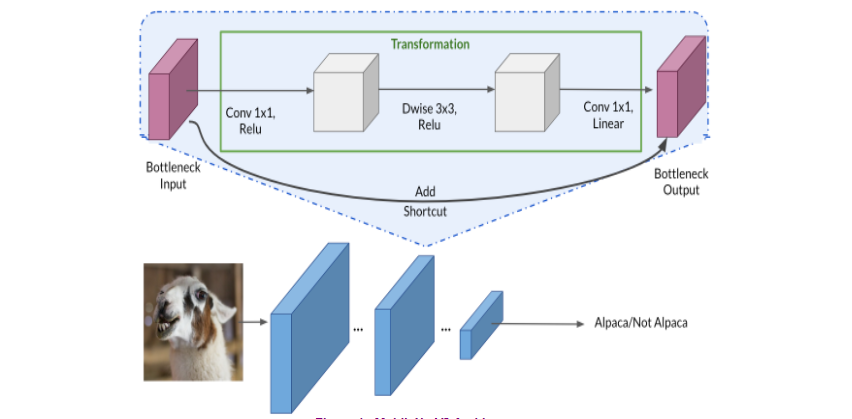

<caption><center> <u> <font color='green'> <b>Figure 1</b> </u></font color='green'>  : <b>MobileNetV2 Architecture</b> <br> Este diagrama está inspirado en el original visto <a href="https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html#:~:text=MobileNetV2%20is%20a%20significant%20improvement,object%20detection%20and%20semantic%20segmentation.">here</a>.</center></caption>

Cada bloque consiste en una estructura residual invertida con un cuello de botella en cada extremo. Estos cuellos de botella codifican las entradas y salidas intermedias en un espacio de baja dimensión y evitan que las no linealidades destruyan información importante. 

Las conexiones de atajo, que son similares a las de las redes residuales tradicionales, tienen el mismo propósito de acelerar el entrenamiento y mejorar las predicciones. Estas conexiones se saltan las convoluciones intermedias y conectan las capas de cuello de botella. 

Vamos a intentar entrenar tu modelo base utilizando todas las capas del modelo preentrenado. 

De forma similar a como se reutilizaron los valores de normalización preentrenados con los que se entrenó MobileNetV2, también se cargarán los pesos preentrenados de ImageNet especificando `weights='imagenet'`. 

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14540800/14536120 [==============================] - 0s 0us/step


Imprime el resumen del modelo para ver todas las capas del modelo, las formas de sus salidas y el número total de parámetros, entrenables y no entrenables. 

In [11]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

Note the last 2 layers here. They are the so called top layers, and they are responsible of the classification in the model

In [12]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


Fíjese en algunas de las capas del resumen, como `Conv2D` y `DepthwiseConv2D`, y en cómo siguen la progresión de expansión a convolución en profundidad a proyección. En combinación con BatchNormalization y ReLU, estas capas constituyen el cuello de botella mencionado anteriormente.

<font color='green'>

**Lo que debe recordar**:

* Las características únicas de MobileNetV2 son: 
  * Convoluciones separables en profundidad que proporcionan un filtrado y una creación de características ligeros.
  * Cuellos de botella de entrada y salida que preservan la información importante en cada extremo del bloque
* Las convoluciones separables en profundidad se ocupan de las dimensiones espaciales y de profundidad (número de canales).

A continuación, elija el primer lote del conjunto de datos tensorflow para utilizar las imágenes, y ejecútelo a través del modelo base MobileNetV2 para probar las predicciones en algunas de sus imágenes.  

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [14]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1], dtype=int32)>

Ahora decodifique las predicciones hechas por el modelo. Antes, al imprimir la forma del lote, habría devuelto (32, 1000). El número 32 se refiere al tamaño del lote y 1000 se refiere a las 1000 clases en las que se preentrenó el modelo. Las predicciones devueltas por el modelo base siguen este formato:

Primero el número de la clase, luego una etiqueta legible para el ser humano y por último la probabilidad de que la imagen pertenezca a esa clase. Observará que hay dos de estas predicciones para cada imagen del lote: son las dos probabilidades más altas para esa imagen.age.

In [15]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

40960/35363 [==================================] - 0s 0us/step


[[('n04589890', 'window_screen', 0.20592292),
  ('n02317335', 'starfish', 0.10664797)],
 [('n04589890', 'window_screen', 0.31899488),
  ('n03598930', 'jigsaw_puzzle', 0.19315633)],
 [('n04589890', 'window_screen', 0.28256157),
  ('n06359193', 'web_site', 0.066800594)],
 [('n04589890', 'window_screen', 0.48841187),
  ('n03530642', 'honeycomb', 0.091118775)],
 [('n04589890', 'window_screen', 0.6286295),
  ('n03530642', 'honeycomb', 0.060480338)],
 [('n03598930', 'jigsaw_puzzle', 0.099785104),
  ('n01694178', 'African_chameleon', 0.04882821)],
 [('n04589890', 'window_screen', 0.8180052),
  ('n03598930', 'jigsaw_puzzle', 0.014480397)],
 [('n04589890', 'window_screen', 0.50537235),
  ('n03530642', 'honeycomb', 0.032941833)],
 [('n04589890', 'window_screen', 0.63768333),
  ('n03530642', 'honeycomb', 0.029194158)],
 [('n04589890', 'window_screen', 0.7454777),
  ('n04209239', 'shower_curtain', 0.03387932)],
 [('n03291819', 'envelope', 0.21836512), ('n06359193', 'web_site', 0.1876467)],
 [('n04

Uh-oh. Aquí hay un montón de etiquetas, algunas de ellas hilarantemente erróneas, pero ninguna dice "alpaca".

Esto se debe a que MobileNet preentrenado sobre ImageNet no tiene las etiquetas correctas para las alpacas, por lo que cuando se utiliza el modelo completo, todo lo que se obtiene es un montón de imágenes clasificadas incorrectamente.

Afortunadamente, puedes eliminar la capa superior, que contiene todas las etiquetas de clasificación, y crear una nueva capa de clasificación.

<a name='3-2'></a>
### 3.2 - Congelación de capas con la API funcional

En las siguientes secciones, verás cómo puedes utilizar un modelo preentrenado para modificar la tarea del clasificador de manera que sea capaz de reconocer alpacas. Puede lograr esto en tres pasos: 

1. Eliminar la capa superior (la capa de clasificación)
    * Establecer `include_top` en `base_model` como False
2. Añadir una nueva capa de clasificación
    * Entrene sólo una capa congelando el resto de la red
    * Como se ha dicho antes, una sola neurona es suficiente para resolver un problema de clasificación binaria.
3. Congelar el modelo base y entrenar la capa clasificadora recién creada
    * Establezca `base model.trainable=False` para evitar cambiar los pesos y entrenar *sólo* la nueva capa
    * Establecer el entrenamiento en `base_model` a False para evitar el seguimiento de las estadísticas en la capa de norma de lote

<a name='ex-2'></a>
### Exercise 2 - alpaca_model

In [45]:
# UNQ_C2
# GRADED FUNCTION
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1)(x)
   
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

Create your new model using the data_augmentation function defined earlier.

In [46]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [47]:
from test_utils import summary, comparator

alpaca_summary = [['InputLayer', [(None, 160, 160, 3)], 0],
                    ['Sequential', (None, 160, 160, 3), 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['Functional', (None, 5, 5, 1280), 2257984],
                    ['GlobalAveragePooling2D', (None, 1280), 0],
                    ['Dropout', (None, 1280), 0, 0.2],
                    ['Dense', (None, 1), 1281, 'linear']] #linear is the default activation

comparator(summary(model2), alpaca_summary)

for layer in summary(model2):
    print(layer)
    

All tests passed!
['InputLayer', [(None, 160, 160, 3)], 0]
['Sequential', (None, 160, 160, 3), 0]
['TensorFlowOpLayer', [(None, 160, 160, 3)], 0]
['TensorFlowOpLayer', [(None, 160, 160, 3)], 0]
['Functional', (None, 5, 5, 1280), 2257984]
['GlobalAveragePooling2D', (None, 1280), 0]
['Dropout', (None, 1280), 0, 0.2]
['Dense', (None, 1), 1281, 'linear']


The base learning rate has been set for you, so you can go ahead and compile the new model and run it for 5 epochs:

In [48]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [49]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 9s 1s/step - loss: 0.7648 - accuracy: 0.5382 - val_loss: 0.5468 - val_accuracy: 0.7692
Epoch 2/5
9/9 [==============================] - 8s 879ms/step - loss: 0.6111 - accuracy: 0.6718 - val_loss: 0.4707 - val_accuracy: 0.6769
Epoch 3/5
9/9 [==============================] - 8s 878ms/step - loss: 0.5268 - accuracy: 0.6527 - val_loss: 0.4185 - val_accuracy: 0.6923
Epoch 4/5
9/9 [==============================] - 8s 891ms/step - loss: 0.4924 - accuracy: 0.7214 - val_loss: 0.3330 - val_accuracy: 0.8000
Epoch 5/5
9/9 [==============================] - 8s 868ms/step - loss: 0.4180 - accuracy: 0.7710 - val_loss: 0.3489 - val_accuracy: 0.7231


Plot the training and validation accuracy:

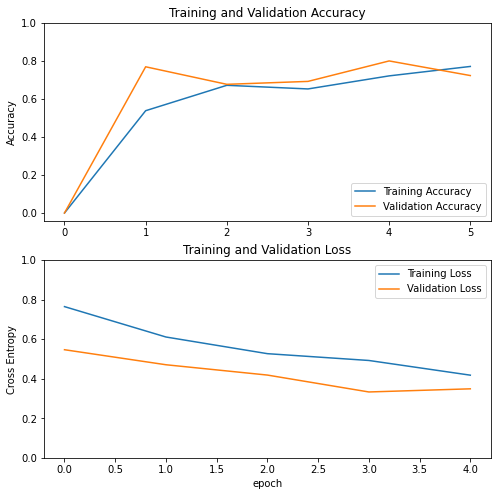

In [50]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [51]:
class_names

['alpaca', 'not alpaca']

The results are ok, but could be better. Next, try some fine-tuning.

<a name='3-3'></a>
### 3.3 - Ajuste del modelo

Puede intentar afinar el modelo volviendo a ejecutar el optimizador en las últimas capas para mejorar la precisión. Cuando se utiliza una tasa de aprendizaje menor, se dan pasos más pequeños para adaptarlo un poco más a los nuevos datos. En el aprendizaje por transferencia, la forma de conseguirlo es descongelando las capas del final de la red y volviendo a entrenar el modelo en las últimas capas con una tasa de aprendizaje muy baja. Si se adapta el ritmo de aprendizaje para repasar estas capas en pasos más pequeños, se pueden obtener más detalles finos y una mayor precisión.

La intuición de lo que ocurre: cuando la red está en sus primeras etapas, se entrena en características de bajo nivel, como los bordes. En las últimas capas, empiezan a surgir características más complejas y de alto nivel, como el pelo ondulado o las orejas puntiagudas. Para el aprendizaje por transferencia, las características de bajo nivel pueden mantenerse igual, ya que tienen características comunes para la mayoría de las imágenes. Cuando se añaden nuevos datos, generalmente se quiere que las características de alto nivel se adapten a ellos, lo que es más bien dejar que la red aprenda a detectar características más relacionadas con sus datos, como el pelo suave o los dientes grandes. 

Para conseguirlo, basta con descongelar las capas finales y volver a ejecutar el optimizador con una tasa de aprendizaje menor, manteniendo todas las demás capas congeladas.

El punto de partida de las capas finales es un poco arbitrario, por lo que se puede jugar un poco con este número. Lo importante es que las últimas capas son la parte de su red que contiene los detalles finos (orejas puntiagudas, colas peludas) que son más específicos para su problema.

En primer lugar, descongele el modelo base estableciendo `base_model.trainable=True`, establezca una capa para el ajuste fino, luego vuelva a congelar todas las capas anteriores. Vuelve a ejecutarlo durante unas cuantas épocas y comprueba si tu precisión ha mejorado.

<a name='ex-3'></a>
### Exercise 3

In [55]:
# UNQ_C3
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  155


In [56]:
assert type(loss_function) == tf.python.keras.losses.BinaryCrossentropy, "Not the correct layer"
assert loss_function.from_logits, "Use from_logits=True"
assert type(optimizer) == tf.keras.optimizers.Adam, "This is not an Adam optimizer"
assert optimizer.lr == base_learning_rate / 10, "Wrong learning rate"
assert metrics[0] == 'accuracy', "Wrong metric"

print('\033[92mAll tests passed!')


All tests passed!


In [57]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 10s 1s/step - loss: 0.4733 - accuracy: 0.7748 - val_loss: 0.2544 - val_accuracy: 0.9077
Epoch 6/10
9/9 [==============================] - 9s 1s/step - loss: 0.2423 - accuracy: 0.9008 - val_loss: 0.1762 - val_accuracy: 0.9077
Epoch 7/10
9/9 [==============================] - 9s 1s/step - loss: 0.2242 - accuracy: 0.8893 - val_loss: 0.1522 - val_accuracy: 0.9385
Epoch 8/10
9/9 [==============================] - 9s 1s/step - loss: 0.2024 - accuracy: 0.8969 - val_loss: 0.0594 - val_accuracy: 0.9846
Epoch 9/10
9/9 [==============================] - 9s 1s/step - loss: 0.1559 - accuracy: 0.9351 - val_loss: 0.0616 - val_accuracy: 0.9846
Epoch 10/10
9/9 [==============================] - 9s 1s/step - loss: 0.1131 - accuracy: 0.9618 - val_loss: 0.1335 - val_accuracy: 0.9385


Ahhh, ¡una gran mejora! Un poco de ajuste puede llegar muy lejos.

In [58]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

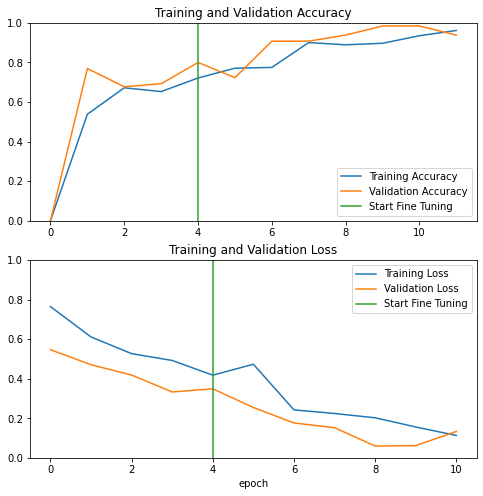

In [59]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<font color='green'>

**Lo que debes recordar**:

* Adaptar el clasificador a los nuevos datos: Elimine la capa superior, añada una nueva capa de clasificación y entrene sólo en esa capa
* Al congelar las capas, evite el seguimiento de las estadísticas (como en la capa de normalización de lotes)
* Afinar las capas finales de su modelo para capturar detalles de alto nivel cerca del final de la red y mejorar potencialmente la precisión 

## Congratulations!

You've completed this assignment on transfer learning and fine-tuning. Here's a quick recap of all you just accomplished:

* Created a dataset from a directory
* Augmented data with the Sequential API
* Adapted a pretrained model to new data with the Functional API and MobileNetV2
* Fine-tuned the classifier's final layers and boosted the model's accuracy

That's awesome! 